## Imports
List Python and ML-related libraries used throughout training.

In [1]:
# Core libraries
import os
import json
import warnings
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Configure warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print('TensorFlow version:', tf.__version__)
print('GPU Available:', tf.config.list_physical_devices('GPU'))

2025-12-02 10:42:29.407413: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764672149.634482      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764672149.697993      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [2]:
# Standard ResNet50 Preprocessing Function
def apply_resnet_preprocessing(image):
    """
    Apply standard ResNet50 preprocessing that matches ImageNet pretraining.
    This uses the official Keras preprocessing function for ResNet models.
    
    CRITICAL: This preprocessing MUST match what was used during ImageNet pretraining:
    - Converts RGB to BGR
    - Subtracts per-channel ImageNet mean: [103.939, 116.779, 123.68] (BGR)
    - No rescaling to [0,1] - works on original pixel values
    
    Args:
        image: Input image (numpy array, expected in 0-255 range)
    
    Returns:
        Preprocessed image (numpy array, mean-subtracted, ~[-123, +132] range)
    """
    from tensorflow.keras.applications.resnet import preprocess_input
    return preprocess_input(image)

print('✓ Standard ResNet50 preprocessing function defined!')
print('  Uses ImageNet mean subtraction - matches pretrained weights exactly.')

✓ Standard ResNet50 preprocessing function defined!
  Uses ImageNet mean subtraction - matches pretrained weights exactly.


## Paths & Configuration
Define dataset roots, metadata paths, and training hyperparameters.

In [3]:
# Check if running in Kaggle environment
IS_KAGGLE = os.path.exists('/kaggle/input')

if IS_KAGGLE:
    # Kaggle paths - Updated for CelebDF-v2 faces dataset
    DATA_ROOT = '/kaggle/input/celebdfv2-faces/content'
    TRAIN_DIR = os.path.join(DATA_ROOT, 'faces', 'train')
    TEST_DIR = os.path.join(DATA_ROOT, 'faces', 'test')
    MODELS_DIR = '/kaggle/working/models'
    PLOTS_DIR = '/kaggle/working/plots'
else:
    # Local paths for testing
    DATA_ROOT = 'data/content'
    TRAIN_DIR = os.path.join(DATA_ROOT, 'faces', 'train')
    TEST_DIR = os.path.join(DATA_ROOT, 'faces', 'test')
    MODELS_DIR = 'models'
    PLOTS_DIR = 'plots'

# Create output directories
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

# Hyperparameters - Optimized for speed
CONFIG = {
    # Data - Dataset is pre-split into train/test
    # Train: ~201K real (class_0) + ~29K fake (class_1) = ~230K total
    # Test: ~12.9K real (class_0) + ~7K fake (class_1) = ~19.9K total
    'val_split': 0.15,  # Use 15% of train data for validation
    'random_state': 42,
    
    # ResNet50 Configuration - Optimized for speed
    'img_size': 224,
    'batch_size': 128,        # Increased from 32 to 64 for faster training
    'phase1_epochs': 1,      # Reduced: Quick head training
    'phase2_epochs': 3,      # Reduced: Fast fine-tuning
    'phase1_lr': 1e-3,
    'phase2_lr': 1e-5,
    'dropout_rate': 0.5,
    
    # Training callbacks - More aggressive for speed
    'early_stopping_patience': 2,
    'reduce_lr_patience': 1,
    'reduce_lr_factor': 0.5,
    'reduce_lr_min': 1e-7,
}

# GPU Configuration
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f'GPU configured: {len(gpus)} GPU(s) available')
    except RuntimeError as e:
        print(e)
else:
    print('Running on CPU')

print('\n=== Configuration ===')
print(f'Data Root: {DATA_ROOT}')
print(f'Train Directory: {TRAIN_DIR}')
print(f'Test Directory: {TEST_DIR}')
print(f'Models Directory: {MODELS_DIR}')
print(f'Plots Directory: {PLOTS_DIR}')
print(f'\nDataset Structure:')
print(f'  - class_0: Real faces (~201K train, ~12.9K test)')
print(f'  - class_1: Fake faces (~29K train, ~7K test)')
print(f'  - Total: ~230K train, ~19.9K test')
print(f'  - Imbalance ratio: ~7:1 (Real:Fake)')
print(f'\nTraining Config (Optimized for ~1 hour on 2x T4 GPUs):')
for key, value in CONFIG.items():
    print(f'  {key}: {value}')
print(f'\nEstimated training time: ~50-70 minutes')


GPU configured: 2 GPU(s) available

=== Configuration ===
Data Root: /kaggle/input/celebdfv2-faces/content
Train Directory: /kaggle/input/celebdfv2-faces/content/faces/train
Test Directory: /kaggle/input/celebdfv2-faces/content/faces/test
Models Directory: /kaggle/working/models
Plots Directory: /kaggle/working/plots

Dataset Structure:
  - class_0: Real faces (~201K train, ~12.9K test)
  - class_1: Fake faces (~29K train, ~7K test)
  - Total: ~230K train, ~19.9K test
  - Imbalance ratio: ~7:1 (Real:Fake)

Training Config (Optimized for ~1 hour on 2x T4 GPUs):
  val_split: 0.15
  random_state: 42
  img_size: 224
  batch_size: 128
  phase1_epochs: 1
  phase2_epochs: 3
  phase1_lr: 0.001
  phase2_lr: 1e-05
  dropout_rate: 0.5
  early_stopping_patience: 2
  reduce_lr_patience: 1
  reduce_lr_factor: 0.5
  reduce_lr_min: 1e-07

Estimated training time: ~50-70 minutes


## Model Definition
Construct the ResNet50 classifier head used for both training phases.

In [4]:
def build_resnet50_model(img_size=224, dropout_rate=0.5, learning_rate=1e-3):
    """
    Build ResNet50 model with custom classification head for binary deepfake detection.
    
    Args:
        img_size: Input image size (default 224 for ResNet50)
        dropout_rate: Dropout rate for regularization
        learning_rate: Learning rate for Adam optimizer
    
    Returns:
        Compiled Keras model
    """
    # Load pre-trained ResNet50 (without top classification layer)
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size, img_size, 3)
    )
    
    # Freeze base model initially (for phase 1 training)
    base_model.trainable = False
    
    # Build custom classification head
    inputs = keras.Input(shape=(img_size, img_size, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, outputs, name='ResNet50_Deepfake_Detector')
    
    # Compile model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc')
        ]
    )
    
    return model

# Enable mixed precision for faster training on compatible GPUs
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Test model creation
print('=== Testing Model Creation ===\n')

print('Creating ResNet50 model...')
resnet_test = build_resnet50_model(
    img_size=CONFIG['img_size'],
    dropout_rate=CONFIG['dropout_rate'],
    learning_rate=CONFIG['phase1_lr']
)
print(f'ResNet50 model created successfully')
print(f'Total params: {resnet_test.count_params():,}')
print(f'Input shape: {resnet_test.input_shape}')
print(f'Output shape: {resnet_test.output_shape}')

# Clean up test model
del resnet_test
tf.keras.backend.clear_session()
print('\nTest model deleted to free memory.')


=== Testing Model Creation ===

Creating ResNet50 model...


I0000 00:00:1764672168.206819      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764672168.207549      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
ResNet50 model created successfully
Total params: 24,768,385
Input shape: (None, 224, 224, 3)
Output shape: (None, 1)

Test model deleted to free memory.


## Class Weighting
Balance the binary classes to reduce bias toward overrepresented samples.

=== Loading Dataset from Directory Structure ===

Checking directories:
Train directory exists: True
Test directory exists: True
Train class_0 exists: True
Train class_1 exists: True
  class_0 (Real) train images: 200,644
  class_1 (Fake) train images: 28,996
Test class_0 exists: True
Test class_1 exists: True
  class_0 (Real) test images: 12,916
  class_1 (Fake) test images: 7,111

=== Training Set Class Distribution ===
Class 0 (Real): 200,644 samples (87.37%)
Class 1 (Fake): 28,996 samples (12.63%)
Total training samples: 229,640
Imbalance ratio (Fake:Real): 0.14:1

=== Computing Class Weights ===
Class weights (balanced):
  Class 0 (Real): 0.5723
  Class 1 (Fake): 3.9599

Class distribution plot saved to: /kaggle/working/plots/class_distribution.png


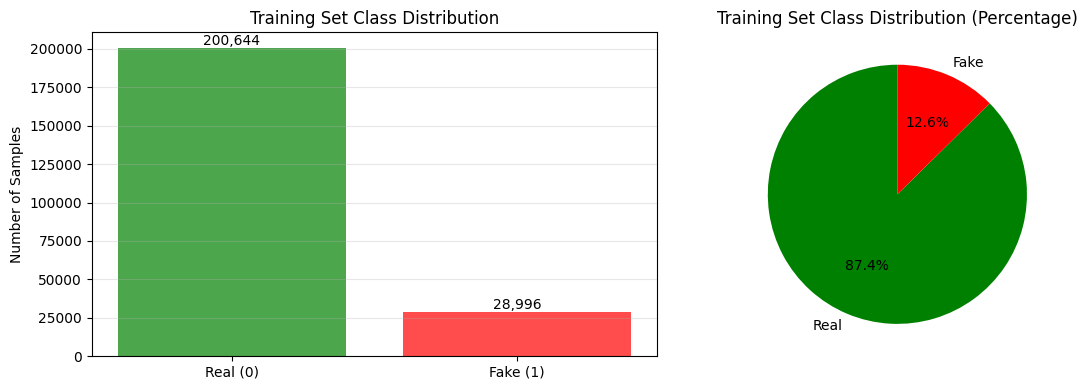

In [5]:
# Load data using ImageDataGenerator from directory structure
print('=== Loading Dataset from Directory Structure ===')

# Verify directories exist
print(f'\nChecking directories:')
print(f'Train directory exists: {os.path.exists(TRAIN_DIR)}')
print(f'Test directory exists: {os.path.exists(TEST_DIR)}')

if os.path.exists(TRAIN_DIR):
    train_class0_path = os.path.join(TRAIN_DIR, 'class_0')
    train_class1_path = os.path.join(TRAIN_DIR, 'class_1')
    print(f'Train class_0 exists: {os.path.exists(train_class0_path)}')
    print(f'Train class_1 exists: {os.path.exists(train_class1_path)}')
    
    if os.path.exists(train_class0_path):
        num_real_train = len([f for f in os.listdir(train_class0_path) if f.endswith('.jpg')])
        print(f'  class_0 (Real) train images: {num_real_train:,}')
    
    if os.path.exists(train_class1_path):
        num_fake_train = len([f for f in os.listdir(train_class1_path) if f.endswith('.jpg')])
        print(f'  class_1 (Fake) train images: {num_fake_train:,}')

if os.path.exists(TEST_DIR):
    test_class0_path = os.path.join(TEST_DIR, 'class_0')
    test_class1_path = os.path.join(TEST_DIR, 'class_1')
    print(f'Test class_0 exists: {os.path.exists(test_class0_path)}')
    print(f'Test class_1 exists: {os.path.exists(test_class1_path)}')
    
    if os.path.exists(test_class0_path):
        num_real_test = len([f for f in os.listdir(test_class0_path) if f.endswith('.jpg')])
        print(f'  class_0 (Real) test images: {num_real_test:,}')
    
    if os.path.exists(test_class1_path):
        num_fake_test = len([f for f in os.listdir(test_class1_path) if f.endswith('.jpg')])
        print(f'  class_1 (Fake) test images: {num_fake_test:,}')

# Calculate total samples and class distribution
if os.path.exists(TRAIN_DIR) and os.path.exists(train_class0_path) and os.path.exists(train_class1_path):
    total_train = num_real_train + num_fake_train
    print(f'\n=== Training Set Class Distribution ===')
    print(f'Class 0 (Real): {num_real_train:,} samples ({num_real_train/total_train*100:.2f}%)')
    print(f'Class 1 (Fake): {num_fake_train:,} samples ({num_fake_train/total_train*100:.2f}%)')
    print(f'Total training samples: {total_train:,}')
    print(f'Imbalance ratio (Fake:Real): {num_fake_train/num_real_train:.2f}:1')
    
    # Compute class weights for balanced training
    print('\n=== Computing Class Weights ===')
    # Create synthetic labels array to compute weights
    labels = np.array([0] * num_real_train + [1] * num_fake_train)
    class_weights_array = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(labels),
        y=labels
    )
    
    # Create class weight dictionary
    class_weights = {i: weight for i, weight in enumerate(class_weights_array)}
    
    print('Class weights (balanced):')
    for class_id, weight in class_weights.items():
        class_name = 'Real' if class_id == 0 else 'Fake'
        print(f'  Class {class_id} ({class_name}): {weight:.4f}')
    
    # Visualize class distribution
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Bar plot
    class_counts = [num_real_train, num_fake_train]
    axes[0].bar(['Real (0)', 'Fake (1)'], class_counts, color=['green', 'red'], alpha=0.7)
    axes[0].set_ylabel('Number of Samples')
    axes[0].set_title('Training Set Class Distribution')
    axes[0].grid(axis='y', alpha=0.3)
    for i, count in enumerate(class_counts):
        axes[0].text(i, count, f'{count:,}', ha='center', va='bottom')
    
    # Pie chart
    axes[1].pie(class_counts, labels=['Real', 'Fake'], autopct='%1.1f%%',
                colors=['green', 'red'], startangle=90)
    axes[1].set_title('Training Set Class Distribution (Percentage)')
    
    plt.tight_layout()
    plot_path = os.path.join(PLOTS_DIR, 'class_distribution.png')
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    print(f'\nClass distribution plot saved to: {plot_path}')
    plt.show()
    
else:
    print(f'\n❌ ERROR: Train directories not found!')
    print('Please ensure the dataset is properly mounted.')


## Data Loading & Splits
Collect image paths from CelebDF, then build train/val/test splits per dataset.

In [6]:
print('=== Creating Data Generators from Directory Structure ===')

def create_data_generators_from_directory(train_dir, test_dir, img_size, batch_size, val_split):
    """
    Create ImageDataGenerator instances for train, validation, and test sets from directory structure.
    
    Args:
        train_dir: Training directory with class_0 and class_1 subdirectories
        test_dir: Test directory with class_0 and class_1 subdirectories
        img_size: Target image size for resizing
        batch_size: Batch size for generators
        val_split: Fraction of training data to use for validation
    
    Returns:
        train_gen, val_gen, test_gen: Data generators
    """
    # Training data augmentation with ResNet preprocessing
    train_datagen = ImageDataGenerator(
        preprocessing_function=apply_resnet_preprocessing,  # Standard ResNet preprocessing
        validation_split=val_split,  # Split training data for validation
        rotation_range=15,  # Standard range for faces
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        zoom_range=0.2,
        brightness_range=[0.8, 1.2],  # Moderate brightness variation
        fill_mode='nearest'
    )
    
    # Test data (standard ResNet preprocessing only)
    test_datagen = ImageDataGenerator(
        preprocessing_function=apply_resnet_preprocessing
    )
    
    # Create training generator (subset='training')
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True,
        seed=CONFIG['random_state'],
        subset='training'  # Use training split
    )
    
    # Create validation generator (subset='validation')
    val_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False,
        seed=CONFIG['random_state'],
        subset='validation'  # Use validation split
    )
    
    # Create test generator
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False
    )
    
    return train_generator, val_generator, test_generator


# Create generators for ResNet50 (224x224)
print(f'\nCreating ResNet50 generators (image size: {CONFIG["img_size"]}x{CONFIG["img_size"]}):')
train_gen, val_gen, test_gen = create_data_generators_from_directory(
    TRAIN_DIR,
    TEST_DIR,
    img_size=CONFIG['img_size'],
    batch_size=CONFIG['batch_size'],
    val_split=CONFIG['val_split']
)

print('\n=== Data Generators Summary ===')
print(f'Train batches: {len(train_gen)} ({train_gen.samples} samples)')
print(f'  Class mapping: {train_gen.class_indices}')
print(f'  Class 0 (Real): {(train_gen.classes == 0).sum()} samples')
print(f'  Class 1 (Fake): {(train_gen.classes == 1).sum()} samples')

print(f'\nValidation batches: {len(val_gen)} ({val_gen.samples} samples)')
print(f'  Class 0 (Real): {(val_gen.classes == 0).sum()} samples')
print(f'  Class 1 (Fake): {(val_gen.classes == 1).sum()} samples')

print(f'\nTest batches: {len(test_gen)} ({test_gen.samples} samples)')
print(f'  Class 0 (Real): {(test_gen.classes == 0).sum()} samples')
print(f'  Class 1 (Fake): {(test_gen.classes == 1).sum()} samples')

print('\n✓ Data generators created successfully!')


=== Creating Data Generators from Directory Structure ===

Creating ResNet50 generators (image size: 224x224):
Found 195195 images belonging to 2 classes.
Found 34445 images belonging to 2 classes.
Found 20027 images belonging to 2 classes.

=== Data Generators Summary ===
Train batches: 1525 (195195 samples)
  Class mapping: {'class_0': 0, 'class_1': 1}
  Class 0 (Real): 170548 samples
  Class 1 (Fake): 24647 samples

Validation batches: 270 (34445 samples)
  Class 0 (Real): 30096 samples
  Class 1 (Fake): 4349 samples

Test batches: 157 (20027 samples)
  Class 0 (Real): 12916 samples
  Class 1 (Fake): 7111 samples

✓ Data generators created successfully!


## Training
Train ResNet50 model with two-phase training (head-only then fine-tuning).

In [7]:
def train_model_two_phase(model_name, build_fn, train_gen, val_gen, config, class_weights):
    """
    Train a model using two-phase approach: head-only training, then fine-tuning.
    
    Args:
        model_name: Name of the model ('ResNet50')
        build_fn: Function to build the model
        train_gen: Training data generator
        val_gen: Validation data generator
        config: Model-specific configuration dictionary
        class_weights: Class weights for balanced training
    
    Returns:
        model: Trained model
        history_phase1: Training history from phase 1
        history_phase2: Training history from phase 2
    """
    print(f'\n{"="*80}')
    print(f'Training {model_name}')
    print(f'{"="*80}')
    
    # ========== PHASE 1: Train head only (frozen backbone) ==========
    print(f'\n--- PHASE 1: Training classification head (backbone frozen) ---')
    
    # Build model
    model = build_fn(
        img_size=config['img_size'],
        dropout_rate=config['dropout_rate'],
        learning_rate=config['phase1_lr']
    )
    
    print(f'Model built with {model.count_params():,} total parameters')
    
    # Count trainable parameters
    trainable_count = sum([tf.size(w).numpy() for w in model.trainable_weights])
    print(f'Trainable parameters in Phase 1: {trainable_count:,}')
    
    # Callbacks for Phase 1
    callbacks_phase1 = [
        ModelCheckpoint(
            os.path.join(MODELS_DIR, f'{model_name}_phase1_best.keras'),
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=CONFIG['early_stopping_patience'],
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=CONFIG['reduce_lr_factor'],
            patience=CONFIG['reduce_lr_patience'],
            min_lr=CONFIG['reduce_lr_min'],
            verbose=1
        )
    ]
    
    # Train Phase 1
    print(f'\nStarting Phase 1 training for {config["phase1_epochs"]} epochs...')
    history_phase1 = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=config['phase1_epochs'],
        class_weight=class_weights,
        callbacks=callbacks_phase1,
        verbose=1
    )
    
    print(f'\nPhase 1 complete!')
    print(f'Best val_loss: {min(history_phase1.history["val_loss"]):.4f}')
    print(f'Best val_accuracy: {max(history_phase1.history["val_accuracy"]):.4f}')
    
    # ========== PHASE 2: Fine-tune entire model ==========
    print(f'\n--- PHASE 2: Fine-tuning entire model ---')
    
    # Unfreeze the base model
    model.layers[1].trainable = True  # layers[1] is the base model (ResNet50)
    
    # Recompile with lower learning rate
    model.compile(
        optimizer=optimizers.Adam(learning_rate=config['phase2_lr']),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc')
        ]
    )
    
    trainable_count = sum([tf.size(w).numpy() for w in model.trainable_weights])
    print(f'Trainable parameters in Phase 2: {trainable_count:,}')
    
    # Callbacks for Phase 2
    callbacks_phase2 = [
        ModelCheckpoint(
            os.path.join(MODELS_DIR, f'{model_name}_phase2_best.keras'),
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=CONFIG['early_stopping_patience'],
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=CONFIG['reduce_lr_factor'],
            patience=CONFIG['reduce_lr_patience'],
            min_lr=CONFIG['reduce_lr_min'],
            verbose=1
        )
    ]
    
    # Train Phase 2
    print(f'\nStarting Phase 2 training for {config["phase2_epochs"]} epochs...')
    history_phase2 = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=config['phase2_epochs'],
        class_weight=class_weights,
        callbacks=callbacks_phase2,
        verbose=1
    )
    
    print(f'\nPhase 2 complete!')
    print(f'Best val_loss: {min(history_phase2.history["val_loss"]):.4f}')
    print(f'Best val_accuracy: {max(history_phase2.history["val_accuracy"]):.4f}')
    
    # Save final model
    final_model_path = os.path.join(MODELS_DIR, f'{model_name}_final.keras')
    model.save(final_model_path)
    print(f'\nFinal model saved to: {final_model_path}')
    
    return model, history_phase1, history_phase2


STARTING RESNET50 TRAINING

Training ResNet50

--- PHASE 1: Training classification head (backbone frozen) ---
Model built with 24,768,385 total parameters
Trainable parameters in Phase 1: 1,180,673

Starting Phase 1 training for 1 epochs...


I0000 00:00:1764672579.749822      63 service.cc:148] XLA service 0x7ab3c0002610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764672579.750842      63 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764672579.750866      63 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764672581.779326      63 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1764672593.444111      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1525/1525 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7074 - auc: 0.7500 - loss: 0.5952 - precision: 0.2548 - recall: 0.6551
Epoch 1: val_loss improved from inf to 0.50859, saving model to /kaggle/working/models/ResNet50_phase1_best.keras
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 4452s 3s/step - accuracy: 0.7074 - auc: 0.7500 - loss: 0.5952 - precision: 0.2549 - recall: 0.6551 - val_accuracy: 0.7755 - val_auc: 0.9033 - val_loss: 0.5086 - val_precision: 0.3446 - val_recall: 0.8627 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.

Phase 1 complete!
Best val_loss: 0.5086
Best val_accuracy: 0.7755

--- PHASE 2: Fine-tuning entire model ---
Trainable parameters in Phase 2: 24,715,265

Starting Phase 2 training for 3 epochs...
Epoch 1/3
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7778 - auc: 0.8609 - loss: 0.4813 - precision: 0.3608 - recall: 0.7889
Epoch 1: val_loss improved from inf to 0.26216, saving model to /kaggle/working/models/ResNet50_phase2_best

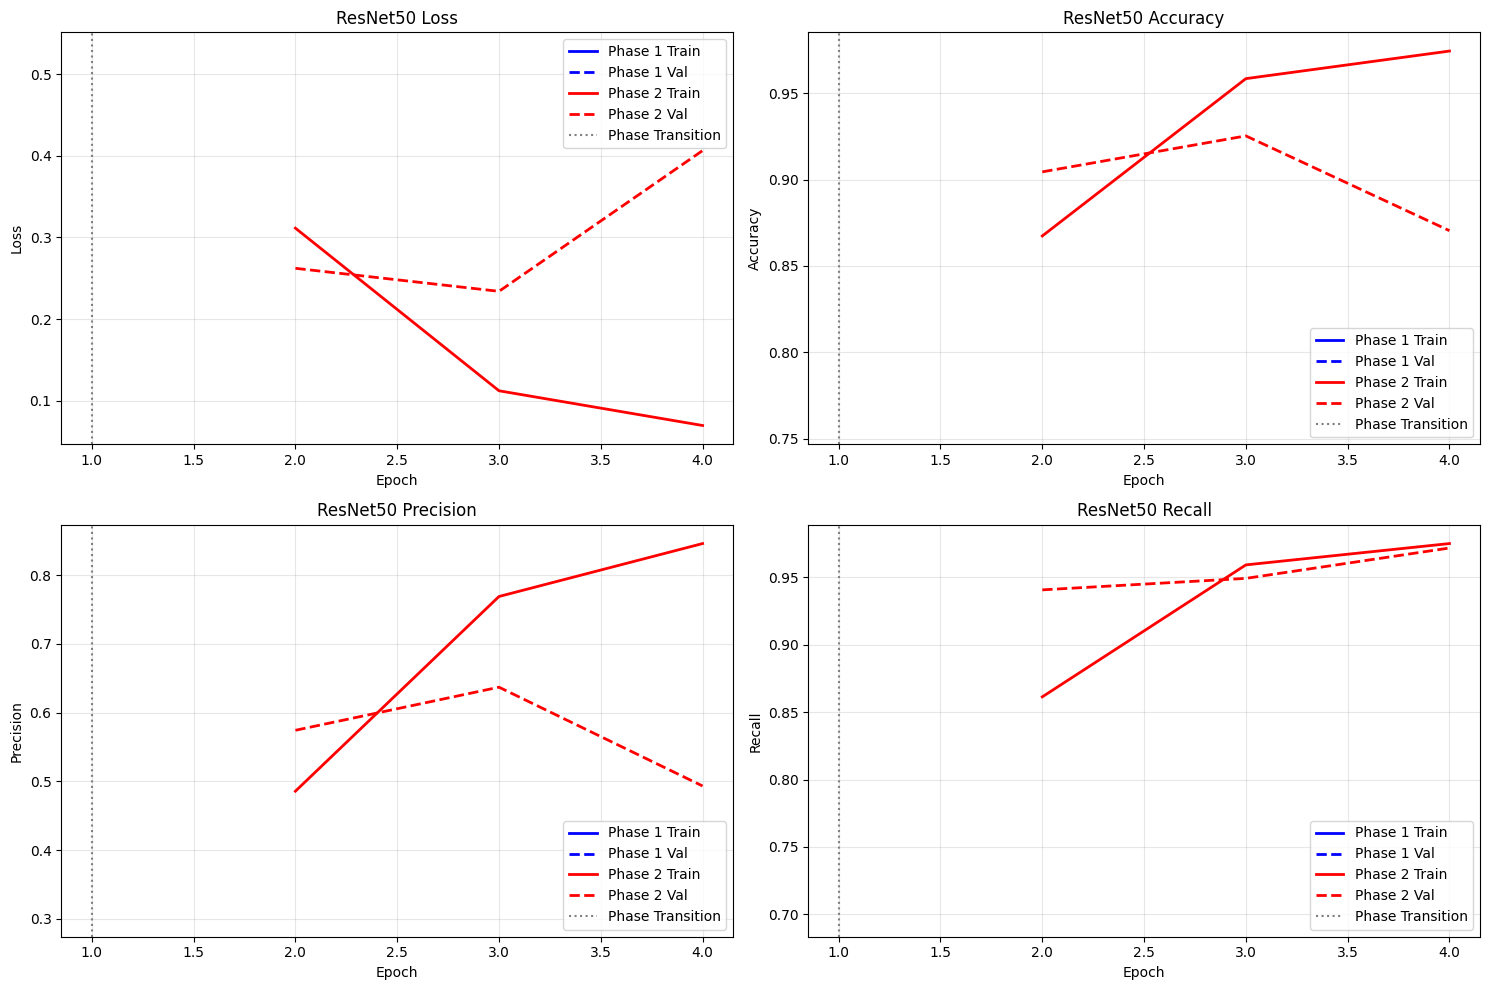


Training model removed from memory to prepare for evaluation.


In [8]:
# ========== TRAIN RESNET50 MODEL ==========
print('\n' + '='*80)
print('STARTING RESNET50 TRAINING')
print('='*80)

# Train ResNet50 with two-phase approach
resnet_model, resnet_history_p1, resnet_history_p2 = train_model_two_phase(
    model_name='ResNet50',
    build_fn=build_resnet50_model,
    train_gen=train_gen,
    val_gen=val_gen,
    config=CONFIG,
    class_weights=class_weights
)

# Plot training history
def plot_training_history(history_p1, history_p2, model_name):
    """Plot training and validation metrics for both phases."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Combine histories
    metrics = ['loss', 'accuracy', 'precision', 'recall']
    titles = ['Loss', 'Accuracy', 'Precision', 'Recall']
    
    for idx, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[idx // 2, idx % 2]
        
        # Phase 1
        epochs_p1 = range(1, len(history_p1.history[metric]) + 1)
        ax.plot(epochs_p1, history_p1.history[metric], 'b-', label=f'Phase 1 Train', linewidth=2)
        ax.plot(epochs_p1, history_p1.history[f'val_{metric}'], 'b--', label=f'Phase 1 Val', linewidth=2)
        
        # Phase 2
        offset = len(epochs_p1)
        epochs_p2 = range(offset + 1, offset + len(history_p2.history[metric]) + 1)
        ax.plot(epochs_p2, history_p2.history[metric], 'r-', label=f'Phase 2 Train', linewidth=2)
        ax.plot(epochs_p2, history_p2.history[f'val_{metric}'], 'r--', label=f'Phase 2 Val', linewidth=2)
        
        # Phase boundary line
        ax.axvline(x=offset, color='gray', linestyle=':', linewidth=1.5, label='Phase Transition')
        
        ax.set_xlabel('Epoch')
        ax.set_ylabel(title)
        ax.set_title(f'{model_name} {title}')
        ax.legend()
        ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plot_path = os.path.join(PLOTS_DIR, f'{model_name.lower()}_training_history.png')
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    print(f'\nTraining history plot saved to: {plot_path}')
    plt.show()

# Plot ResNet50 training history
plot_training_history(resnet_history_p1, resnet_history_p2, 'ResNet50')

# Clean up to free memory
del resnet_model
tf.keras.backend.clear_session()
print('\nTraining model removed from memory to prepare for evaluation.')

In [9]:
print('\n' + '='*80)
print('RESNET50 TRAINING COMPLETE!')
print('='*80)
print(f'\nTrained model saved in: {MODELS_DIR}')
print('Models available:')
print('  - ResNet50_phase1_best.keras')
print('  - ResNet50_phase2_best.keras')
print('  - ResNet50_final.keras')



RESNET50 TRAINING COMPLETE!

Trained model saved in: /kaggle/working/models
Models available:
  - ResNet50_phase1_best.keras
  - ResNet50_phase2_best.keras
  - ResNet50_final.keras


## Evaluation
Evaluate ResNet50 model on test set.


MODEL EVALUATION ON TEST SET

Evaluating ResNet50
Loading model from: /kaggle/working/models/ResNet50_final.keras
Generating predictions on test set...
157/157 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step

=== ResNet50 Test Results ===
Accuracy:  0.9348
Precision: 0.9529
Recall:    0.8588
F1-Score:  0.9034
AUC-ROC:   0.9841

Confusion Matrix:
[[12614   302]
 [ 1004  6107]]

Classification Report:
              precision    recall  f1-score   support

        Real       0.93      0.98      0.95     12916
        Fake       0.95      0.86      0.90      7111

    accuracy                           0.93     20027
   macro avg       0.94      0.92      0.93     20027
weighted avg       0.94      0.93      0.93     20027

Confusion matrix plot saved to: /kaggle/working/plots/resnet50_confusion_matrix.png


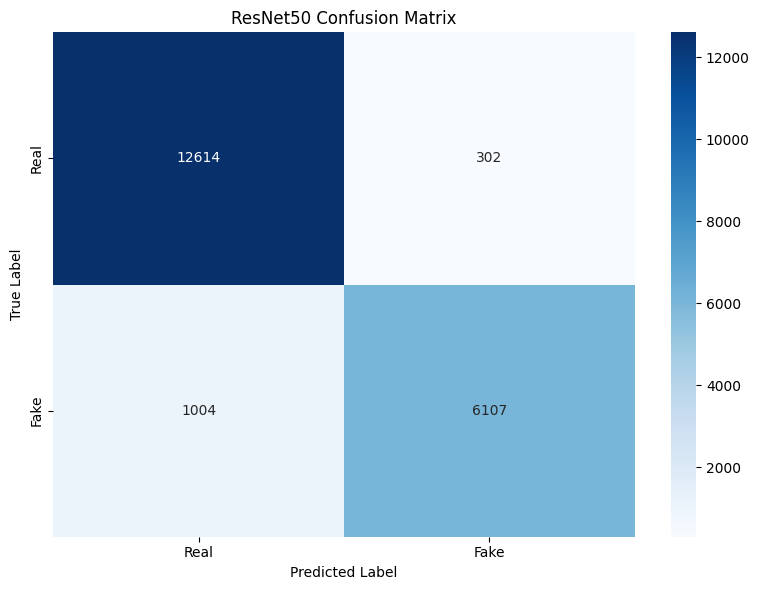


=== ResNet50 ROC Curve ===
ROC curve saved to: /kaggle/working/plots/resnet50_roc_curve.png


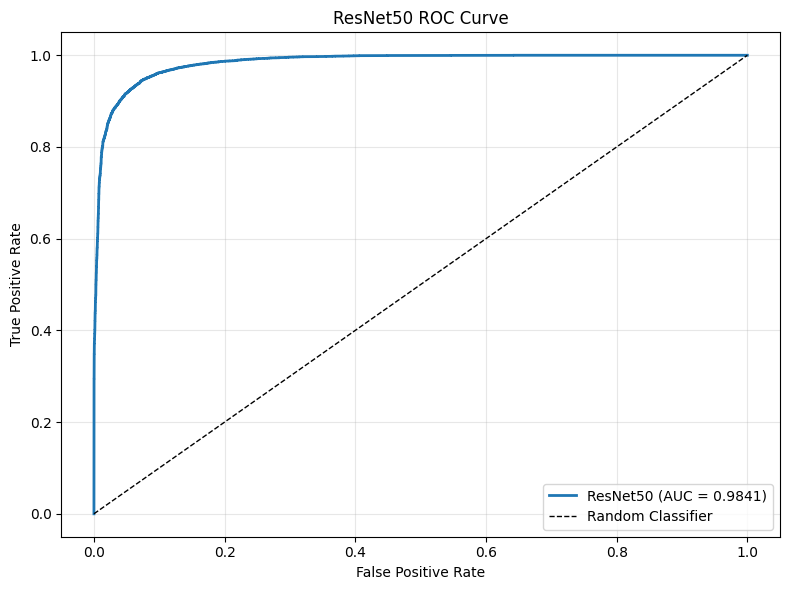


=== ResNet50 Test Results Summary ===


,Model,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,ResNet50,0.9348,0.9529,0.8588,0.9034,0.9841


In [10]:
def plot_confusion_matrix(cm, model_name):
    """
    Plot confusion matrix heatmap.
    
    Args:
        cm: Confusion matrix (2x2 numpy array)
        model_name: Name of the model for title
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Real', 'Fake'], 
                yticklabels=['Real', 'Fake'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f'{model_name} Confusion Matrix')
    plt.tight_layout()
    plot_path = os.path.join(PLOTS_DIR, f'{model_name.lower()}_confusion_matrix.png')
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    print(f'Confusion matrix plot saved to: {plot_path}')
    plt.show()


def evaluate_model(model_path, test_gen, model_name):
    """
    Evaluate a trained model on the test set.
    
    Args:
        model_path: Path to the saved model
        test_gen: Test data generator
        model_name: Name of the model for reporting
    
    Returns:
        Dictionary with evaluation metrics and predictions
    """
    print(f'\n{"="*80}')
    print(f'Evaluating {model_name}')
    print(f'{"="*80}')
    
    # Load model
    print(f'Loading model from: {model_path}')
    model = keras.models.load_model(model_path)
    
    # Get predictions
    print('Generating predictions on test set...')
    test_gen.reset()
    y_pred_prob = model.predict(test_gen, verbose=1)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    y_true = test_gen.classes
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred_prob)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    print(f'\n=== {model_name} Test Results ===')
    print(f'Accuracy:  {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall:    {recall:.4f}')
    print(f'F1-Score:  {f1:.4f}')
    print(f'AUC-ROC:   {auc_score:.4f}')
    print(f'\nConfusion Matrix:')
    print(cm)
    print(f'\nClassification Report:')
    print(classification_report(y_true, y_pred, target_names=['Real', 'Fake']))
    
    # Clean up
    del model
    tf.keras.backend.clear_session()
    
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_score,
        'confusion_matrix': cm,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_prob': y_pred_prob.flatten()
    }


# ========== EVALUATE RESNET50 MODEL ==========
print('\n' + '='*80)
print('MODEL EVALUATION ON TEST SET')
print('='*80)

# Evaluate ResNet50
resnet_results = evaluate_model(
    model_path=os.path.join(MODELS_DIR, 'ResNet50_final.keras'),
    test_gen=test_gen,
    model_name='ResNet50'
)
plot_confusion_matrix(resnet_results['confusion_matrix'], 'ResNet50')

# Plot ROC curve for ResNet50
print('\n=== ResNet50 ROC Curve ===')
from sklearn.metrics import roc_curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(resnet_results['y_true'], resnet_results['y_pred_prob'])
plt.plot(fpr, tpr, label=f"ResNet50 (AUC = {resnet_results['auc']:.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ResNet50 ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plot_path = os.path.join(PLOTS_DIR, 'resnet50_roc_curve.png')
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f'ROC curve saved to: {plot_path}')
plt.show()

# Summary table
print('\n=== ResNet50 Test Results Summary ===')
summary_df = pd.DataFrame([
    {
        'Model': 'ResNet50',
        'Accuracy': f"{resnet_results['accuracy']:.4f}",
        'Precision': f"{resnet_results['precision']:.4f}",
        'Recall': f"{resnet_results['recall']:.4f}",
        'F1-Score': f"{resnet_results['f1']:.4f}",
        'AUC-ROC': f"{resnet_results['auc']:.4f}"
    }
])
display(summary_df)


## Video-Level Testing on Unseen Data
Test the trained models on unseen video files by extracting frames, running predictions, and aggregating results per video.


VIDEO-LEVEL AGGREGATION AND TESTING

--- ResNet50 Video-Level Analysis ---

Video aggregation summary:
Total videos: 518
Frames per video (mean): 38.7
Frames per video (range): 11 - 64

=== ResNet50 Video-Level Results ===
Total videos: 518
Real videos: 340
Fake videos: 178

Video-Level Metrics:
Accuracy:  0.9633
Precision: 0.9818
Recall:    0.9101
F1-Score:  0.9446
AUC-ROC:   0.9962

Confusion Matrix:
[[337   3]
 [ 16 162]]

FRAME-LEVEL vs VIDEO-LEVEL COMPARISON


,Model,Level,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,ResNet50,Frame,0.9348,0.9529,0.8588,0.9034,0.9841
1,ResNet50,Video,0.9633,0.9818,0.9101,0.9446,0.9962



Frame vs Video comparison plot saved to: /kaggle/working/plots/resnet50_frame_vs_video.png


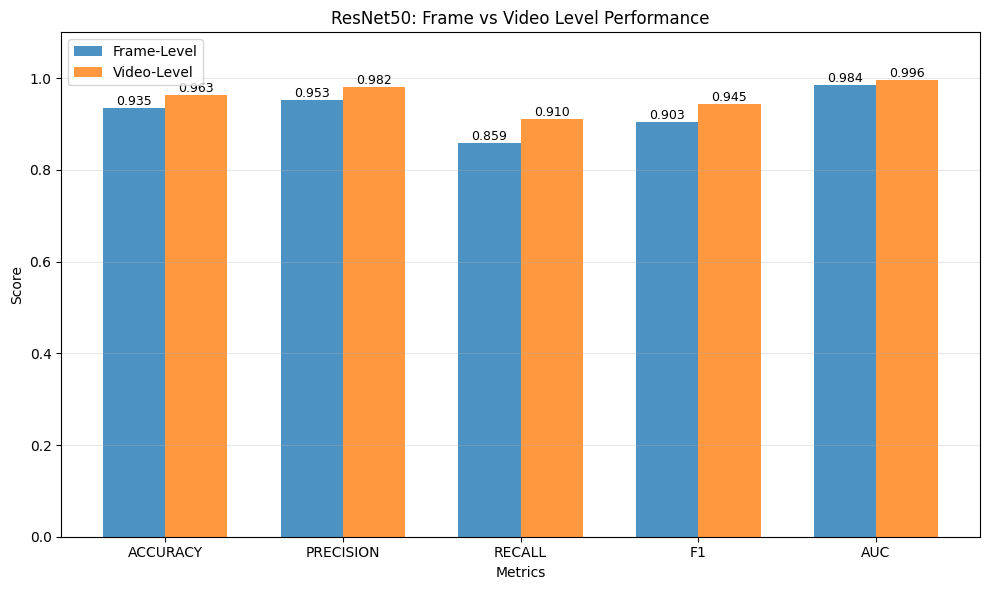

Video-level results saved to: /kaggle/working/plots/resnet50_video_level_results.csv

VIDEO-LEVEL EVALUATION COMPLETE!

📊 Summary:
   - Total videos evaluated: 518
   - Frame-level and video-level metrics compared
   - Results saved to: /kaggle/working/plots/resnet50_video_level_results.csv


In [11]:
print('\n' + '='*80)
print('VIDEO-LEVEL AGGREGATION AND TESTING')
print('='*80)

def extract_video_id_from_filepath(filepath):
    """
    Extract video ID from filepath.
    New format: class_1/00000_0.jpg -> 00000
    Extract base ID before the frame index (_0, _10, etc.)
    """
    filename = os.path.basename(filepath)
    # Remove extension and frame index (everything after last underscore)
    parts = filename.rsplit('.', 1)[0]  # Remove .jpg
    video_id = parts.rsplit('_', 1)[0]  # Remove frame index (_0, _10, etc.)
    return video_id


def aggregate_video_predictions(filepaths, labels, predictions, pred_probs):
    """
    Aggregate frame-level predictions to video-level.
    
    Args:
        filepaths: List of image filepaths
        labels: Frame-level true labels
        predictions: Frame-level binary predictions
        pred_probs: Frame-level prediction probabilities
    
    Returns:
        DataFrame with video-level aggregated predictions
    """
    # Create dataframe with predictions
    df_pred = pd.DataFrame({
        'filepath': filepaths,
        'label': labels,
        'pred': predictions,
        'pred_prob': pred_probs
    })
    
    # Extract video IDs
    df_pred['video_id'] = df_pred['filepath'].apply(extract_video_id_from_filepath)
    
    # Aggregate by video
    video_agg = df_pred.groupby('video_id').agg({
        'label': 'first',  # All frames from same video have same label
        'pred': lambda x: (x.mean() > 0.5).astype(int),  # Majority vote
        'pred_prob': 'mean',  # Average probability
        'filepath': 'count'  # Number of frames per video
    }).rename(columns={'filepath': 'num_frames'})
    
    video_agg['video_pred'] = (video_agg['pred_prob'] > 0.5).astype(int)
    
    return video_agg


def evaluate_video_level(video_agg, model_name):
    """
    Evaluate video-level predictions.
    
    Args:
        video_agg: DataFrame with video-level aggregated predictions
        model_name: Name of the model
    
    Returns:
        Dictionary with video-level metrics
    """
    y_true = video_agg['label'].values
    y_pred = video_agg['video_pred'].values
    y_pred_prob = video_agg['pred_prob'].values
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_pred_prob)
    cm = confusion_matrix(y_true, y_pred)
    
    print(f'\n=== {model_name} Video-Level Results ===')
    print(f'Total videos: {len(video_agg)}')
    print(f'Real videos: {(y_true == 0).sum()}')
    print(f'Fake videos: {(y_true == 1).sum()}')
    print(f'\nVideo-Level Metrics:')
    print(f'Accuracy:  {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall:    {recall:.4f}')
    print(f'F1-Score:  {f1:.4f}')
    print(f'AUC-ROC:   {auc_score:.4f}')
    print(f'\nConfusion Matrix:')
    print(cm)
    
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc_score,
        'confusion_matrix': cm,
        'num_videos': len(video_agg)
    }


# ========== RESNET50 VIDEO-LEVEL TESTING ==========
print('\n--- ResNet50 Video-Level Analysis ---')

# Get test file paths from generator
test_filepaths = test_gen.filepaths
test_labels = test_gen.classes

# Aggregate ResNet50 predictions
video_agg_resnet = aggregate_video_predictions(
    test_filepaths,
    test_labels,
    resnet_results['y_pred'],
    resnet_results['y_pred_prob']
)

print(f'\nVideo aggregation summary:')
print(f'Total videos: {len(video_agg_resnet)}')
print(f'Frames per video (mean): {video_agg_resnet["num_frames"].mean():.1f}')
print(f'Frames per video (range): {video_agg_resnet["num_frames"].min()} - {video_agg_resnet["num_frames"].max()}')

video_results_resnet = evaluate_video_level(video_agg_resnet, 'ResNet50')


# ========== FRAME-LEVEL vs VIDEO-LEVEL COMPARISON ==========
print('\n' + '='*80)
print('FRAME-LEVEL vs VIDEO-LEVEL COMPARISON')
print('='*80)

comparison_data = [
    {
        'Model': 'ResNet50',
        'Level': 'Frame',
        'Accuracy': f"{resnet_results['accuracy']:.4f}",
        'Precision': f"{resnet_results['precision']:.4f}",
        'Recall': f"{resnet_results['recall']:.4f}",
        'F1-Score': f"{resnet_results['f1']:.4f}",
        'AUC-ROC': f"{resnet_results['auc']:.4f}"
    },
    {
        'Model': 'ResNet50',
        'Level': 'Video',
        'Accuracy': f"{video_results_resnet['accuracy']:.4f}",
        'Precision': f"{video_results_resnet['precision']:.4f}",
        'Recall': f"{video_results_resnet['recall']:.4f}",
        'F1-Score': f"{video_results_resnet['f1']:.4f}",
        'AUC-ROC': f"{video_results_resnet['auc']:.4f}"
    }
]

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)

# Visualize frame vs video comparison
plt.figure(figsize=(10, 6))

metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
frame_vals = [resnet_results[m] for m in metrics]
video_vals = [video_results_resnet[m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

bars1 = plt.bar(x - width/2, frame_vals, width, label='Frame-Level', alpha=0.8)
bars2 = plt.bar(x + width/2, video_vals, width, label='Video-Level', alpha=0.8)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('ResNet50: Frame vs Video Level Performance')
plt.xticks(x, [m.upper() for m in metrics])
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, 1.1)
plt.tight_layout()

plot_path = os.path.join(PLOTS_DIR, 'resnet50_frame_vs_video.png')
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f'\nFrame vs Video comparison plot saved to: {plot_path}')
plt.show()

# Save video-level results
video_results_path = os.path.join(PLOTS_DIR, 'resnet50_video_level_results.csv')
video_agg_resnet['model'] = 'ResNet50'
video_agg_resnet.to_csv(video_results_path, index=True)
print(f'Video-level results saved to: {video_results_path}')


print('\n' + '='*80)
print('VIDEO-LEVEL EVALUATION COMPLETE!')
print('='*80)
print(f'\n📊 Summary:')
print(f'   - Total videos evaluated: {len(video_agg_resnet)}')
print(f'   - Frame-level and video-level metrics compared')
print(f'   - Results saved to: {video_results_path}')
